<a href="https://colab.research.google.com/github/abhash896/Neural_network_training_on_GPU/blob/master/GANS/Generative_adversarial_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Generative Adversarial Networks (GANs) in PyTorch

## Introduction to Generative Modeling

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose.

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.


There are two neural networks: a Generator and a Discriminator.

The generator generates a 'fake' sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is 'real' (picked from the training data) or 'fake' (generated by the generator). Training happens in tandem. We train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization.

We will use the Anime Face Dataset which consists of over 63000 cropped anime faces. Note that generative modeling is an unsupervised learning task, so the images do not have any labels.

# Downloading and Exploring the Data

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:12<00:00, 32.3MB/s]


The dataset has a single folder called images which contains all 63000 plus images in JPG format.

In [7]:
import os
data_dir = './animefacedataset'
print(os.listdir(data_dir))

['images']


In [8]:
print(os.listdir(data_dir + '/images')[:4])

['27853_2009.jpg', '24394_2008.jpg', '19919_2007.jpg', '27342_2009.jpg']


Let's load this dataset using the ImageFolder class from torchvision. we will also resize and crop the images to 64 x 64 and normalize the pixel values with a mean and standard deviation of 0.5 for each channel.

This will ensure that the pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [10]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [11]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))


train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle = True, 
                      num_workers = 2, 
                      pin_memory = True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [12]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def denormalize(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow = 8).permute(1, 2, 0))

def show_batch(dl, nmax= 64):
  for images, _ in dl:
    show_images(images, nmax)
    break

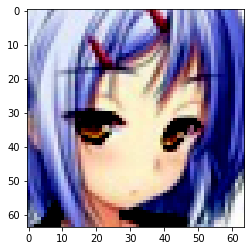

In [14]:
for image, _ in train_dl:
  plt.imshow(image[16].permute(1, 2, 0))
  break

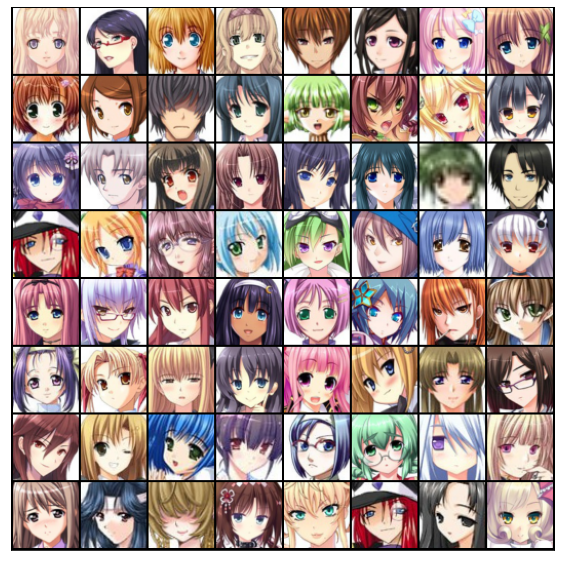

In [15]:
show_batch(train_dl)

# Using a GPU

In [16]:
def get_default_device():
  '''Pick GPU if avaialble, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')

  else:
    return torch.device('cpu')

def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [17]:
class DeviceDataLoader():
  '''Wrap a data_loader to move data to a device'''
  def __init__(self, data_loader, device):
    self.data_loader = data_loader
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to a device'''
    for b in self.data_loader:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.data_loader)

In [18]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

The discriminator takes an image as input and tries to classify it as 'real' or 'generated'. In this sense, it's like any other neural network. We will use a convolutional neural network (CNN) which outputs a single number output for every image. We will use stride of 2 to progressively reduce the size of the output feature map.

In [20]:
import torch.nn as nn

In [21]:
discriminator = nn.Sequential(
    # input: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    # output: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    # output: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    # output: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    # output: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    # output: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

In [22]:
discriminator = to_device(discriminator, device)

# Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achieve this, we will use the `ConvTranspose2d` layer from PyTorch, which is performed to as a transposed convolution (also referred to as a deconvolution).

In [23]:
latent_size = 128

In [24]:
generator = nn.Sequential(
    # input: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # output: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # output: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # output: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # output: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    # output: 3 x 64 x 64
)

The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling."

Note that since the outputs of the TanH activation lie in the range [-1,1], we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.



torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


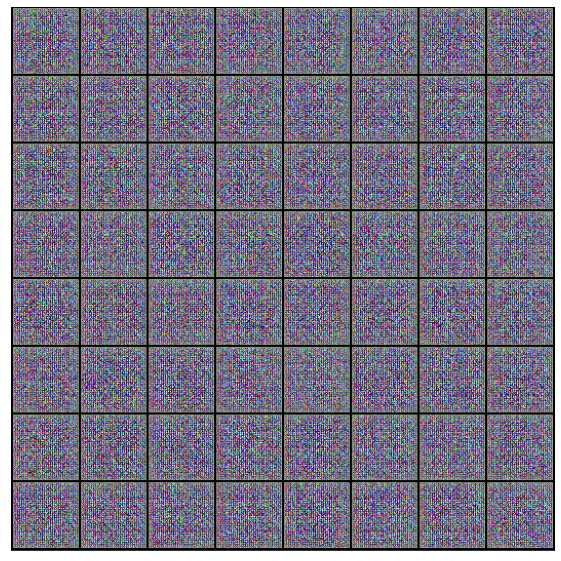

In [25]:
xb = torch.randn(batch_size, latent_size, 1 ,1)    # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

torch.Size([1, 3, 64, 64])


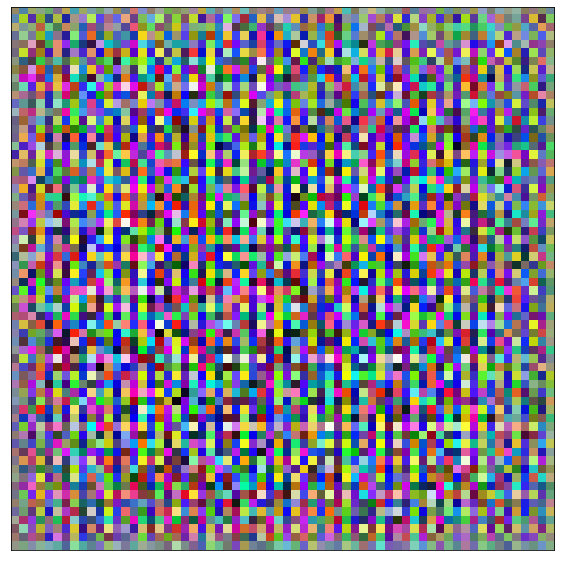

In [26]:
xb = torch.randn(1, latent_size, 1 ,1)    # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we have not trained it yet.

In [27]:
generator = to_device(generator, device)

# Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between the real and generated images.

In [28]:
def train_discriminator(real_images, opt_d):

  '''We are going to give one batch of images as input, so one batch of training is going to be performed by the function.'''

  # clear discriminator gradients
  opt_d.zero_grad()

  # opt_d is an optimizer that is set up to modify the parameters of the discriminator.
  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device = device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()    # This can be used as an evaluation matrix to see how well our discriminator is doing. We want it to be as close to 1 as possible for it to become good at detecting real images.

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
  fake_images = generator(latent)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()    # # This can be used as an evaluation matrix to see how well our discriminator is doing. We want it to be as close to 0 as possible for it to become good at detecting fake images.

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()    # This is the discriminator's optimizer. It will optimize the parameters of the optimizer. (modify the weights of the discriminator)
  return loss.item(), real_score, fake_score


Here are the steps involved in training the discriminator:

We expect the discriminator to output 1 if the image was picked from the real dataset, and 0 if it was generated using the generator network.

We first pass a batch of real images, and compute the loss, setting the target labels to 1.

Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

**It's important to note that we don't change the weights of the generator model while training the discriminator** (`opt_d` only affects the `discriminator.parameters()`)

# Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass them into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [29]:
def train_generator(opt_g):
  # opt_g is an optimizer for the generator
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1 ,device = device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator weights
  loss.backward()
  opt_g.step()    # This is going to update the weights of the generator.

  return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We will also create a helper function to export the generated images.

In [30]:
from torchvision.utils import save_image
# This library is used to save the generated image

In [31]:
sample_dir = 'generated'
os.mkdir(sample_dir)


In [32]:
def save_samples(index, latent_tensors, show = True):
  fake_images = generator(latent_tensors)
  fake_fname = f'generated_image_{index}.png'
  save_image(denormalize(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
  print('Saving', fake_fname)

  if show:
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

We will use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

In [33]:
fixed_latent = torch.randn(64, latent_size, 1 , 1, device = device)

Saving generated_image_0.png


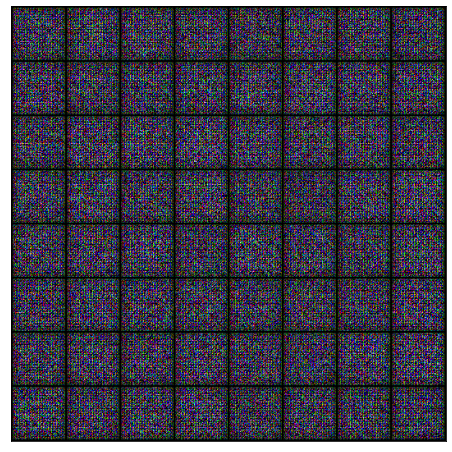

In [34]:
save_samples(0, fixed_latent)

# Full Training Loop

Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We will use Adam optimizer with some custom parameters (betas) that are known to work well for GANs.

In [35]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [36]:
def fit(epochs, lr, start_idx = 1):
  '''start_idx is used for naming the files that are saved at the end of each epoch.'''

  torch.cuda.empty_cache()    # It empties the CUDA cache so that there is not previous memory and we have fresh GPU memory to use for each epoch.

  # Losses and scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers

  opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses and scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses and scores (last batch)
    print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g}, loss_d: {loss_d}, real_score: {real_score}, fake_score: {fake_score}")

    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show = False)

  return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between training the generator and the discriminator.

In [37]:
lr = 0.0002
epochs = 25

In [38]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.077964782714844, loss_d: 0.6120619773864746, real_score: 0.6242344975471497, fake_score: 0.02061532996594906
Saving generated_image_1.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 2.952852249145508, loss_d: 0.7645772099494934, real_score: 0.5839602947235107, fake_score: 0.04587789624929428
Saving generated_image_2.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.266155242919922, loss_d: 0.3923671841621399, real_score: 0.7892099618911743, fake_score: 0.1038774698972702
Saving generated_image_3.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.850581169128418, loss_d: 0.655812680721283, real_score: 0.6255531311035156, fake_score: 0.009959034621715546
Saving generated_image_4.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 7.123052597045898, loss_d: 0.41191041469573975, real_score: 0.9248063564300537, fake_score: 0.22850966453552246
Saving generated_image_5.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.5846452713012695, loss_d: 0.09388864040374756, real_score: 0.9424690008163452, fake_score: 0.02816450037062168
Saving generated_image_6.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.267068862915039, loss_d: 0.22729060053825378, real_score: 0.9531644582748413, fake_score: 0.14731040596961975
Saving generated_image_7.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.913565635681152, loss_d: 0.18788960576057434, real_score: 0.9039116501808167, fake_score: 0.036362212151288986
Saving generated_image_8.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.2738447189331055, loss_d: 0.20806090533733368, real_score: 0.8612504601478577, fake_score: 0.01117958314716816
Saving generated_image_9.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 7.488524913787842, loss_d: 0.5528835654258728, real_score: 0.6945953965187073, fake_score: 0.00014084370923228562
Saving generated_image_10.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 7.561352729797363, loss_d: 0.12803210318088531, real_score: 0.9707708954811096, fake_score: 0.08715510368347168
Saving generated_image_11.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 10.490019798278809, loss_d: 0.2755080759525299, real_score: 0.8576672077178955, fake_score: 0.00023830066493246704
Saving generated_image_12.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 9.352888107299805, loss_d: 0.04022837430238724, real_score: 0.9678047299385071, fake_score: 0.004033394157886505
Saving generated_image_13.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.8343963623046875, loss_d: 0.10263235867023468, real_score: 0.9400555491447449, fake_score: 0.03007723204791546
Saving generated_image_14.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.106805801391602, loss_d: 0.07737143337726593, real_score: 0.9611243605613708, fake_score: 0.028643202036619186
Saving generated_image_15.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 6.87080192565918, loss_d: 0.05296721309423447, real_score: 0.9793976545333862, fake_score: 0.028993193060159683
Saving generated_image_16.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 17.88593101501465, loss_d: 1.2629114389419556, real_score: 0.4893651306629181, fake_score: 3.6845557715992072e-09
Saving generated_image_17.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.257122993469238, loss_d: 0.05412345007061958, real_score: 0.9779229164123535, fake_score: 0.026934154331684113
Saving generated_image_18.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 6.323331832885742, loss_d: 0.06023796275258064, real_score: 0.9822385907173157, fake_score: 0.038961105048656464
Saving generated_image_19.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 8.1839017868042, loss_d: 0.022422004491090775, real_score: 0.9829158782958984, fake_score: 0.003975059371441603
Saving generated_image_20.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 8.435436248779297, loss_d: 0.16874240338802338, real_score: 0.9840635061264038, fake_score: 0.12936526536941528
Saving generated_image_21.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 7.893815040588379, loss_d: 0.15188872814178467, real_score: 0.9624677300453186, fake_score: 0.09513089060783386
Saving generated_image_22.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 9.023490905761719, loss_d: 0.03739183396100998, real_score: 0.9816094636917114, fake_score: 0.017580587416887283
Saving generated_image_23.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 9.994544982910156, loss_d: 0.03900642693042755, real_score: 0.976020336151123, fake_score: 0.01119445264339447
Saving generated_image_24.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 16.101726531982422, loss_d: 0.1488441675901413, real_score: 0.9056193232536316, fake_score: 2.912247509812005e-05
Saving generated_image_25.png


In [51]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 8.28475570678711, loss_d: 0.018501006066799164, real_score: 0.9941627979278564, fake_score: 0.012332526035606861
Saving generated_image_1.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 8.003585815429688, loss_d: 0.03538588806986809, real_score: 0.9939121603965759, fake_score: 0.027388717979192734
Saving generated_image_2.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 13.447799682617188, loss_d: 0.22269318997859955, real_score: 0.9933226108551025, fake_score: 0.1771504133939743
Saving generated_image_3.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 11.09681224822998, loss_d: 0.18334220349788666, real_score: 0.9702578186988831, fake_score: 0.12031443417072296
Saving generated_image_4.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.36900520324707, loss_d: 0.07457378506660461, real_score: 0.9647399187088013, fake_score: 0.028577229008078575
Saving generated_image_5.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 8.161359786987305, loss_d: 0.07937881350517273, real_score: 0.9462674856185913, fake_score: 0.012083922512829304
Saving generated_image_6.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.556516647338867, loss_d: 0.13307785987854004, real_score: 0.9595307111740112, fake_score: 0.050794314593076706
Saving generated_image_7.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 8.748122215270996, loss_d: 0.061873242259025574, real_score: 0.9830419421195984, fake_score: 0.03576144203543663
Saving generated_image_8.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 26.214679718017578, loss_d: 0.8757888078689575, real_score: 0.9999989867210388, fake_score: 0.2682429850101471
Saving generated_image_9.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.115725040435791, loss_d: 0.0598628893494606, real_score: 0.9647607207298279, fake_score: 0.019038863480091095
Saving generated_image_10.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 9.703032493591309, loss_d: 0.01686001941561699, real_score: 0.992077112197876, fake_score: 0.008412261493504047
Saving generated_image_11.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 17.015613555908203, loss_d: 0.12468543648719788, real_score: 0.9883826971054077, fake_score: 0.08578561991453171
Saving generated_image_12.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 11.580288887023926, loss_d: 0.02653387002646923, real_score: 0.9784365296363831, fake_score: 0.000270174874458462
Saving generated_image_13.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 21.875511169433594, loss_d: 0.01005885936319828, real_score: 0.999840497970581, fake_score: 0.008915374055504799
Saving generated_image_14.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.120924949645996, loss_d: 0.04650840908288956, real_score: 0.9705460071563721, fake_score: 0.013470754027366638
Saving generated_image_15.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.109123229980469, loss_d: 0.1618419587612152, real_score: 0.9183244705200195, fake_score: 0.015690680593252182
Saving generated_image_16.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.98838996887207, loss_d: 0.021398209035396576, real_score: 0.9976103901863098, fake_score: 0.018439730629324913
Saving generated_image_17.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 8.068161010742188, loss_d: 0.08226466178894043, real_score: 0.9539579153060913, fake_score: 0.007495256140828133
Saving generated_image_18.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 16.97666358947754, loss_d: 0.18759876489639282, real_score: 0.9974872469902039, fake_score: 0.1522868126630783
Saving generated_image_19.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 7.095483779907227, loss_d: 0.062232065945863724, real_score: 0.9697672128677368, fake_score: 0.01343266386538744
Saving generated_image_20.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 2.848456382751465, loss_d: 0.1975673884153366, real_score: 0.8898225426673889, fake_score: 0.009677820838987827
Saving generated_image_21.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 7.628695487976074, loss_d: 0.014363925904035568, real_score: 0.9948270916938782, fake_score: 0.00886469054967165
Saving generated_image_22.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 6.8186540603637695, loss_d: 0.030811872333288193, real_score: 0.9910495281219482, fake_score: 0.02113381400704384
Saving generated_image_23.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.257424354553223, loss_d: 0.13820752501487732, real_score: 0.9308547973632812, fake_score: 0.0064834170043468475
Saving generated_image_24.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.422011375427246, loss_d: 0.018871424719691277, real_score: 0.989821195602417, fake_score: 0.008172178640961647
Saving generated_image_25.png


In [39]:
losses_g, losses_d, real_scores, fake_scores = history   

Saving the model weights and biases.

In [40]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Let's look at the generated images after the 1st, 5th and 10th epochs of training.

In [41]:
from IPython.display import Image

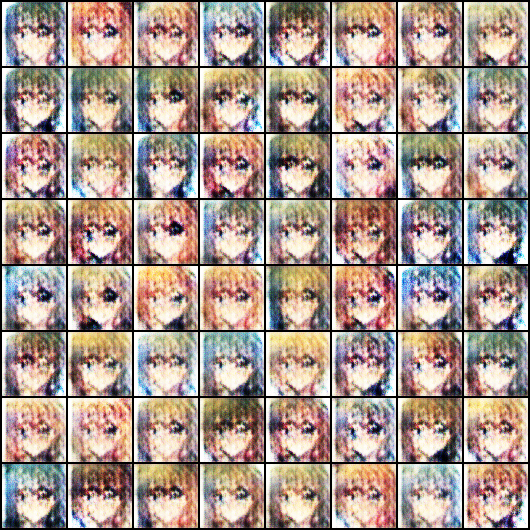

In [43]:
Image('./generated/generated_image_1.png')

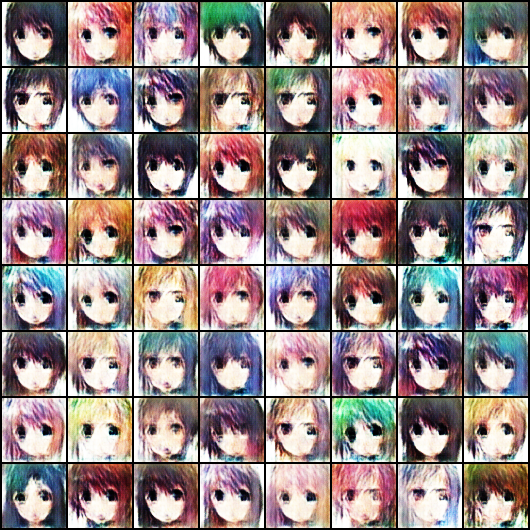

In [44]:
Image('./generated/generated_image_5.png')

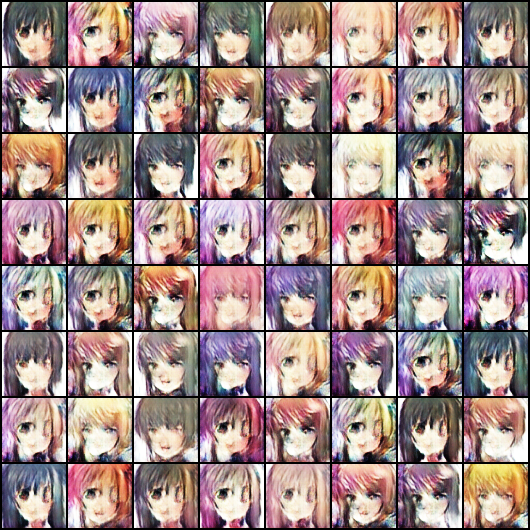

In [45]:
Image('./generated/generated_image_15.png')

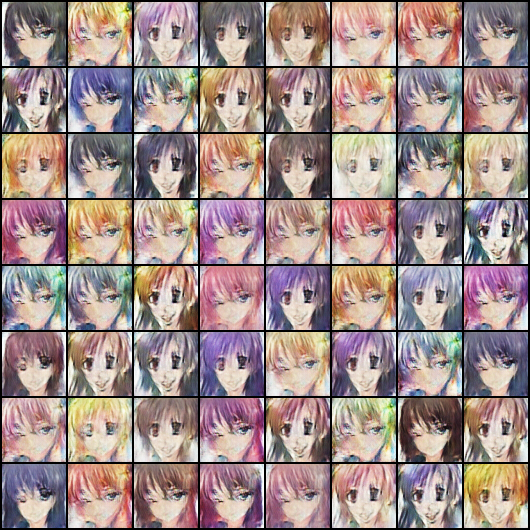

In [46]:
Image('./generated/generated_image_20.png')

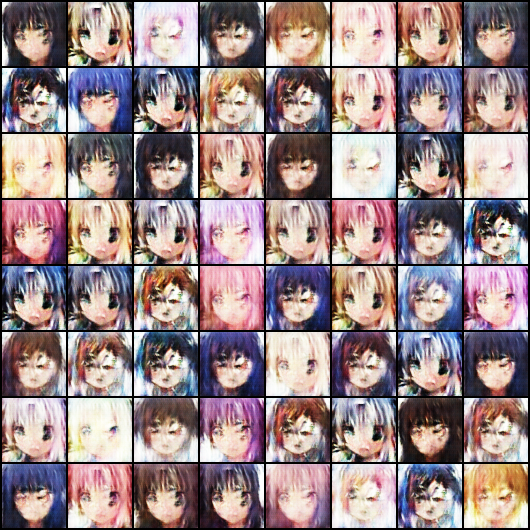

In [47]:
Image('./generated/generated_image_25.png')

In [66]:
xb = torch.randn(1, latent_size, 1 ,1)
xb = to_device(xb, device)    # random latent tensors

#to_device(data, device)
fake_images = generator(xb)
print(fake_images.shape)
#show_images(fake_images)

torch.Size([1, 3, 64, 64])


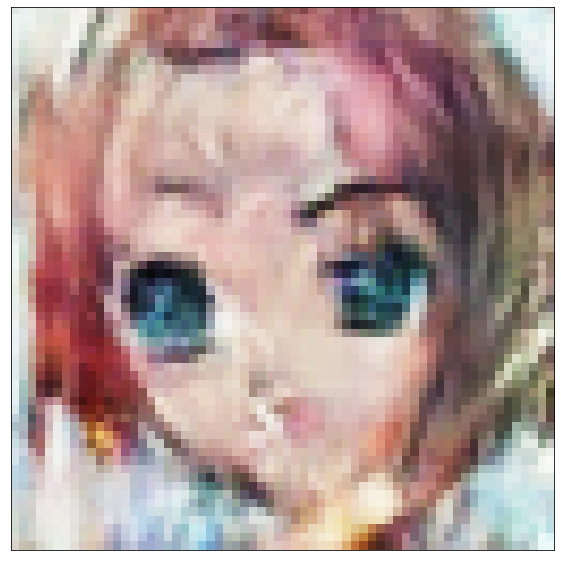

In [67]:
show_images(fake_images.cpu())

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [52]:
import cv2
import os

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

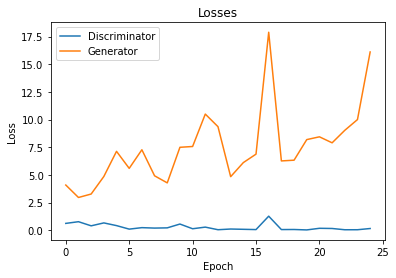

In [53]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

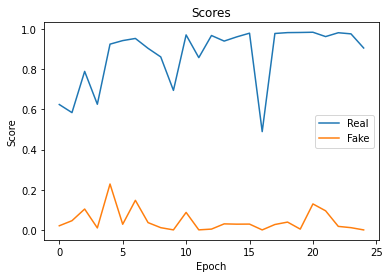

In [54]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

We can train the generator maybe twice per batch to see an improvement is the performance.